## Part 3 - Modelling, Simulations, Decisions

This part is concerned with acutally predicting the profitability of doing an arbitrage trade. It consits of three parts:
1. Modelling of Perpetual Prices
2. Monte Carlo (MC) Simulation of potential profits
3. Decision analysis

First we will load all our perpetual data again.

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from matplotlib import style
import seaborn as sns
from IPython.core.pylabtools import figsize
import warnings
import glob
import statsmodels.api as sm
import datetime


%matplotlib inline
plt.style.use('ggplot')

np.random.seed(17098234)

In [69]:
df = pd.read_csv('downloads/BTC-PERPETUAL.txt')

In [70]:
df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
df.index = df['date']
df = df.drop(columns=['timestamp', 'date', 'instrument_name'])
df.columns = ['perpetual', 'index']

In [71]:
df['ratio'] = df['perpetual'] / df['index']

In [72]:
df['funding'] = np.maximum(0.0005, df['ratio'] - 1) +  np.minimum(-0.0005, df['ratio'] - 1)

In [73]:
df_D = df.resample('D').last()
df_5 = df.resample('5Min').last().interpolate()

In [74]:
df_H = df.resample('H').last().interpolate()

## Time Series Analysis

In [ ]:
time = datetime(2019, 5, 12, )
train, test = df_H[]

In [32]:
warnings.simplefilter('ignore')
res = sm.tsa.arma_order_select_ic(df_H['ratio'], max_ar=5, max_ma=5, ic=['bic'], trend='c')

Best is (2, 3)

In [75]:
model = sm.tsa.ARMA(df_H['ratio'], (2, 3)).fit(disp=False)

In [ ]:
model.summary()

In [82]:
df_H['2019-05-12'].between_time('7:00', '9:00')

,perpetual,index,ratio,funding
date,,,,
2019-05-12 07:00:00,7524.00,7528.13,0.999451,-0.000049
2019-05-12 08:00:00,7435.75,7434.24,1.000203,0.000000
2019-05-12 09:00:00,7378.25,7379.22,0.999869,0.000000


## Monte Carlo Simulation

Let's calculate the profitability of arbitrage, given those prices from earlier that I sampled from a random moment in time.

In [34]:
# Starting prices
start_future_price = 7270.13
start_perpetual_price = 7325.88
start_index_price = 7335.49

I make a few assumptions:

1. The trades are done with 1 BTC of exposure.
2. The BTC index price at the future's expiration date will be a random number picked from a normal distribution around the current index price.
3. The volatility of BTC is about 4% daily, based on a quick look [here](https://www.sk3w.co/options).
3. The perpetual price at the future's expiration date will equal the index price, times by a perpetual index ratio sampled from our modeled distribution.

Here's the full model specification as:

$$\text{btc_std} \sim U(0.1, 0.3)$$
$$\text{end_index_price} \sim N(\text{start_index_price}, \text{btc_std})$$
$$\text{perpetual_index_ratio} \sim \text{ARMA Process}$$
$$\text{end_perpetual_price} = \text{end_index_price} * \text{perpetual_index_ratio}$$
$$\text{funding_rate} = f(\text{perpetual_index_ratio})$$
$$\text{total_funding} = \text{total funding payments through time} = f(\text{funding_rate})$$
$$\text{profit} = f(\text{end_index_price}, \text{end_perpetual_price}, \text{total_funding})$$


In [35]:
# Initial Prices are the set of of index, perpetual, and futures prices I recorded and used in the example earlier.
# This will simulate the profit considering you bought and sold for those prices.
# Enter in new prices to get a profitibility analysis for those prices

# Number of monte carlo trials
trials = 10000

# Amount of BTC
btc = 1

# days until settlement - May 12 to June 28
days = 46

# Daily standard deviation of bitcoin price in percentage
daily_btc_sd = scipy.stats.norm.rvs(loc=0.04, scale=0.005, size=trials)

# Can't go below 0
daily_btc_sd = np.maximum(daily_btc_sd, 0)

# Standard deviation of time period
btc_sd = daily_btc_sd * np.sqrt(days)

# Standard deviation in dollars
index_sd = start_index_price * btc_sd

# Generate a list of values normally distributed around the starting index price
end_index_price = start_index_price + index_sd * np.random.randn(trials)

# Max of these values and 1, so that the bitcoin index isn't negative
end_index_price = np.maximum(end_index_price, np.ones(trials))

In [65]:
def arma_sample(c, ar, ma, sd, y, resid, steps):
    """Generates arma process values from the end of y
    
    Parameters
    --------------------------------------------------
    y: data
    resid: residuals from arma model estimation
    c: coefficient
    ar: list of ar coefficients
    ma: list of ma coefficients
    sd: standard deviation of innovation
    steps: number of forward steps
    """
    initial_length = len(y)
    y = y.tolist()
    resid = resid.tolist()
    for _ in range(periods):
        yhat = c
        for i, value in enumerate(ar):
            yhat += value * y[~i]
        for i, value in enumerate(ma):
            yhat += value * resid[~i]
        u = sd * np.random.randn()
        yhat += u
        y.append(yhat)
        resid.append(u)
    return y[initial_length:]

In [52]:
def ar_sample(y, c, ar, sd, steps):
    """Generates ar process values from the end of y
    
    Parameters
    --------------------------------------------------
    y: data
    c: coefficient
    ar: list of ar coefficients
    sd: standard deviation of innovation
    steps: number of steps forward to forecast
    """
    initial_length = len(y)
    y = y.tolist()
    for _ in range(steps):
        yhat = c
        for i, value in enumerate(ar):
            yhat += value * y[~i]
        u = sd * np.random.randn()
        yhat += u
        y.append(yhat)
    return y[initial_length:]    

In [50]:
np.sqrt(model.sigma2)

0.0005278886652563803

In [64]:
arma_sample(model.params[0], model.arparams, model.maparams, np.sqrt(model.sigma2), df_H['ratio'], periods)

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [41]:
periods = days * 24
ratios = np.array([])
for i in range(trials):
    ratios[i] = arma_sample(model.params[0], model.arparams, model.maparams, model.sigma2, df_H['ratio'], periods)
ratios

TypeError: cannot concatenate object of type '<class 'numpy.float64'>'; only Series and DataFrame objs are valid

In [16]:
# Generate ending perpetual prices from the index
end_perpetual_ratio = ppc[:,0]
end_perpetual_price = end_index_price * end_perpetual_ratio

# On deribit futures are restricted to contracts of $10
# That means your expoure might not be perfectly equal in long and short
future_amount = round(start_future_price * btc, -1)
perpetual_amount = round(start_perpetual_price * btc, -1)


# Payoffs from long future, short perpetual
long_future_payoff = future_amount * (1/start_future_price - 1/end_index_price) * end_index_price
short_perpetual_payoff = -perpetual_amount * (1/start_perpetual_price - 1/end_perpetual_price) * end_index_price

short_perpetual_profit = long_future_payoff + short_perpetual_payoff

# Payoffs from short future, long perpetual
short_future_payoff = -future_amount * (1/start_future_price - 1/end_index_price) * end_index_price
long_perpetual_payoff = perpetual_amount * (1/start_perpetual_price - 1/end_perpetual_price) * end_index_price

long_perpetual_profit = short_future_payoff + long_perpetual_payoff

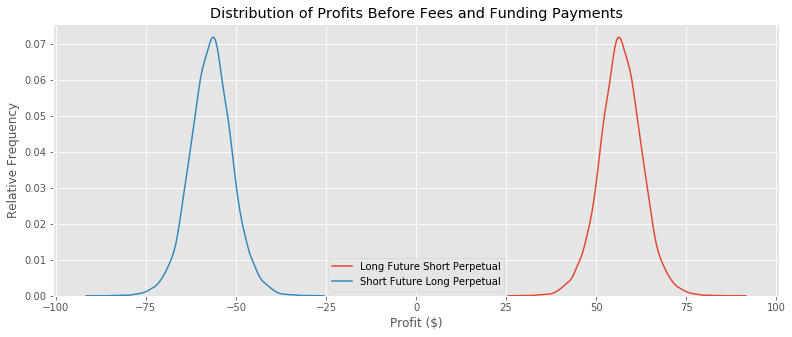

In [17]:
figsize(13, 5)
sns.kdeplot(short_perpetual_profit, label='Long Future Short Perpetual')
sns.kdeplot(long_perpetual_profit, label='Short Future Long Perpetual')
plt.xlabel('Profit ($)')
plt.ylabel('Relative Frequency')
plt.title('Distribution of Profits Before Fees and Funding Payments')
plt.show()

### Fees

Our model has not included any fees. So we will do those calculations and update our profits.

The fees for trading on Deribit can be found [here](https://www.deribit.com/pages/information/fees)

The fees are as follows all in percentage of underlying asset (negative numbers mean a rebate):

Instrument | Maker Trade Fee | Taker Trade Fee | Delivery Fee
--- | --- | --- | ---
Future | 0.05% | -0.02% | 0.025%
Perpetual | 0.075% | -0.025% | 0.075%

Thus it is possible that we actually earn profit on trades by only setting limit orders. If only limit orders are used our total fees would be:

Trade | Fees
--- | ---
Buy Future | -0.02%
Sell Perpetual | -0.025%
Settle Future | 0.025%
Buy Perpetual | -0.025%

For a total rebate of 0.045% of the underlying asset.

If we used all market orders the fees would be:

Trade | Fees
--- | ---
Buy Future | 0.05%
Sell Perpetual | 0.075%
Settle Future | 0.025%
Buy Perpetual | 0.075%

For a total fee amount of 0.225%.

In [18]:
taker_fees = start_index_price * 0.225 / 100

maker_rebate = start_index_price * 0.045 / 100

short_perpetual_taker = short_perpetual_profit - taker_fees
short_perpetual_maker = short_perpetual_profit + maker_rebate

long_perpetual_taker = long_perpetual_profit - taker_fees
long_perpetual_maker = long_perpetual_profit + maker_rebate

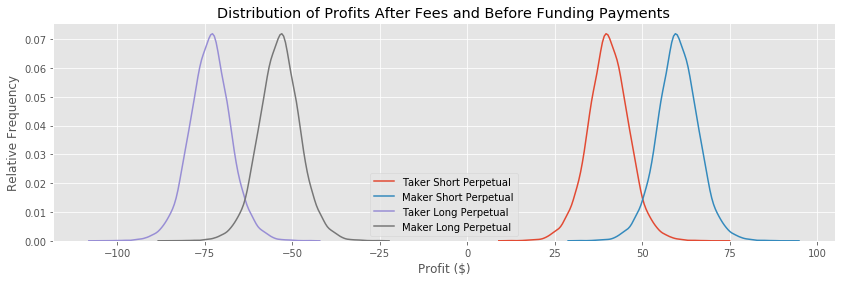

In [19]:
figsize(14,4)
sns.kdeplot(short_perpetual_taker, label='Taker Short Perpetual')
sns.kdeplot(short_perpetual_maker, label='Maker Short Perpetual')
sns.kdeplot(long_perpetual_taker, label='Taker Long Perpetual')
sns.kdeplot(long_perpetual_maker, label='Maker Long Perpetual')
plt.xlabel('Profit ($)')
plt.ylabel('Relative Frequency')
plt.title('Distribution of Profits After Fees and Before Funding Payments')
plt.show()

In [20]:
# Calculate funding costs

# We want an average funding over the whole period.
# Thus we calculate funding at each point in time and average
individual_moment_funding = np.maximum(0.0005, ppc - 1) +  np.minimum(-0.0005, ppc - 1)

# Now we have a bunch of estimates of funding rates at 5 min intervals.
# We want to find the average funding rate over a 1 month period
# To do this we average over 1 month of 5 minute intervals.
# That corresponds to averageing over 12 * 24 * 30 = 8640 funding rate averages.

individual_moment_funding.shape

(10000, 8660)

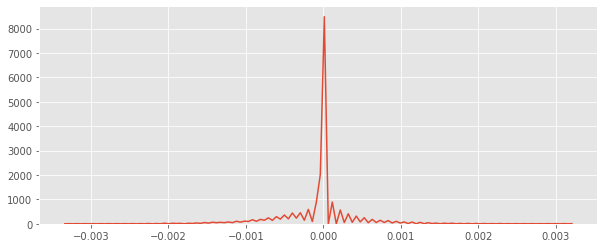

In [40]:
sns.kdeplot(individual_moment_funding[69])

In [80]:
a_f = individual_moment_funding[:,0:2].mean(axis=1)

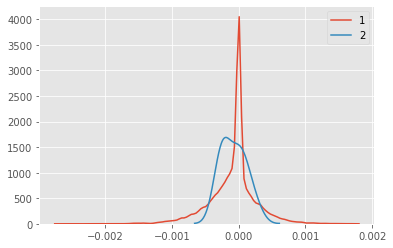

In [81]:
sns.kdeplot(a_f, label='1')
sns.kdeplot(df['funding'].resample('S').mean().interpolate().resample('M').mean(), label='2')

In [21]:
# Thus we can just do a mean accross the rows, because 8660 is close to our desired 8640

average_funding = individual_moment_funding.mean(axis=1)

# The listed funding rates are for 8 hour intervals.

funding_payments = perpetual_amount * average_funding * 3 * days

In [22]:
funding_payments.mean()

-74.10291794328322

In [23]:
# Calculate funding costs

final_short_perpetual_taker = short_perpetual_taker + funding_payments
final_short_perpetual_maker = short_perpetual_maker + funding_payments

final_long_perpetual_taker = long_perpetual_taker - funding_payments
final_long_perpetual_maker = long_perpetual_maker - funding_payments

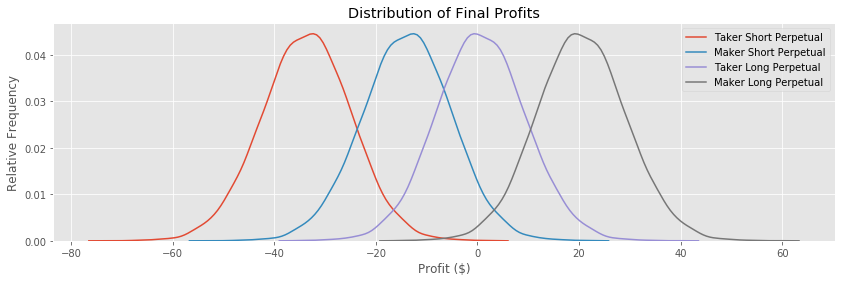

In [24]:
figsize(14,4)
sns.kdeplot(final_short_perpetual_taker, label='Taker Short Perpetual')
sns.kdeplot(final_short_perpetual_maker, label='Maker Short Perpetual')
sns.kdeplot(final_long_perpetual_taker, label='Taker Long Perpetual')
sns.kdeplot(final_long_perpetual_maker, label='Maker Long Perpetual')
plt.xlabel('Profit ($)')
plt.ylabel('Relative Frequency')
plt.title('Distribution of Final Profits')
plt.show()

## Analysis

There are a number of interesting results.
1. The expected perpetual index ratio is just slightly below 1. This causes shorting the perpetual to have sort of a constant interest effect. The amount of this effect is quite large, resulting in an average of over \\$70 of funding payments.
2. Orginally it looked like we could profit from shorting the perpetual and going long on the future, because the future was about \\$50 cheaper. But the \\$70 in funding payments from the holders of the short perpetual to the holders of the long perpetual more than compensates for that. It makes going long on the perpetual the profitable option. This is very unexpected. Basic arbitrage suggests that you should buy the cheap one and sell the expensive one. But this model suggests to buy the expensive one, and sell the cheap one becuase the funding payments will be worth it. 

In [25]:
# Annualized average funding rate
average_funding.mean() * 3 * 365

-0.08021699107093654

The annual funding rate is about 8% to hold a short perpetual. Interestingly, 8% annually is also probably your expected interest rate while shorting bitcoin itself. And infact we would expect these rates to be similar.

A short perpetual offers the exact same sort of exposure that shorting bitcoin does. Thus we expect a simliar willingness to pay interest for that exposure. Which means that the longs get payments of about 8% annually.

I choose the perpetual and future prices at a random moment in time. It would be unusual if we discovered arbitrage oppurtunies in that moment, which would suggest large market inefficienes. Instead we see that the funding payments are approximaly balancing out the differne in price with potential for profits if take advantage of the maker refund. 

The prices I randomly selected are not that unusal. We can see here how they correspond to the historical data.

In [26]:
# Get a list of files with the historical data
files = glob.glob('downloads/futures/*.txt')

# Combine the files into one large pandas df
data_list = []
for file in files:
    data = pd.read_csv(file)
    data_list.append(data)
df_futures = pd.concat(data_list)

df_futures['ratio'] = df_futures['price'] / df_futures['index_price']

instrument_names = ['BTC-27JUL18', 'BTC-31AUG18', 'BTC-28SEP18', 'BTC-28DEC18', 'BTC-29MAR19']

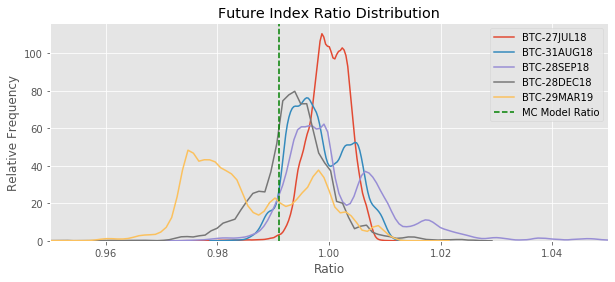

In [27]:
figsize(10,4)
for i, instrument in enumerate(instrument_names):
    temp = df_futures[df_futures['instrument_name'] == instrument]
    sns.kdeplot(temp['ratio'], label=instrument)
plt.xlabel('Ratio')
plt.ylabel('Relative Frequency')
plt.title('Future Index Ratio Distribution')
plt.xlim(0.95, 1.05)
specific_ratio=start_future_price/start_index_price
plt.axvline(x=specific_ratio, color='g', linestyle='--', label='MC Model Ratio')
plt.legend()   
plt.show()

## Problems with the Model

This model is almost certainly wrong. It doesn't come close to capturing the complextiy of reality. But it might be useful. Let's look at where it is probably going to break down.

The single biggest assumption I made is to model the perpetual index ratio at any point in time as a random draw from a t-distribution. That is a pretty good assumption for **long** time periods. This model completely ignores the fact that the ratios from moment to moment are autocorrelated.

For example. If I knew that the perpetual was trading 1% lower than the index, I would expect the price 5 minutes later to be a completely independent random number. We would expect the perpetual index ratio to still be about 0.99, maybe slightly higher or lower. We could see that in Part 2, the ratios are auto correlated for a few days. Thus this model will absolutly fail while trying to predict the profits from arbitraging a future that expires in 2 days. It will only work on longer time spans, probably greater than 2 weeks. At that point the perpetual index ratios really will resemble random draws.

This error is compounded due to the funding rates. We saw from Part 2 how drastically the funding rates could vary. The funding rates hit 150% and -150% annual interest at some points. Which would mean massive transfers from longs to shorts or shorts to longs in those moments. But our model's profits are fairly consistent. By taking an arbitrage position of 1 bitcoin, our model says that your profits should fall within a ~\\$40 range.

This is because the perpetual index ratio balances out and averages very close to 1 overtime, even if it has huge momentary swings.

### Improvements

To model a short term arbitrage you would absolutely need a time series model of the perpetual index ratio. My first attempt would be a random walk with pressure pushing the ratio towards 1 if the ratio goes outside the 0.9995 to 1.0005 bounds where there are no funding payments. But that is research for another day.

## Rate of Return

The model suggests that going long on the perpetual and going short on the future would result in profits. Our profits seemed to be within the range of \\$0 to \\$40, with an mode at about \\$20. But those profits require margin to be posted for the futures.

Deribit has a portfolio margin system where your required margin is a function of your total portfolio risk due to bitcoin price fluctions. The details are [here](https://www.deribit.com/pages/docs/portfoliomargin). As we are neutral on bitcoin, our required margin is only 1.2%. But we would still need margin to cover fluctuations in the funding rate.

My 90% confidence interval (CI) is that you would want more than 2% and less than 5% of your exposure in the perpetual. This is just based on a quick reading of the portfolio margin system and some quick calculations about how much you would have to pay if you got unlucky with funding rates for a few days in a row. More experimentation with Deribit's trading system would be needed to reduce this uncertainty.

So I will use a random number drawn from a normal distribution to model the amount of margin required.

In [29]:
# There are 3.29 standard deviatins in a 90% CI

margin_sd = (0.05 - 0.02) / 3.29
margin_mean = (0.05 + 0.02) / 2

margin_percent = margin_mean + margin_sd * np.random.randn(trials)

# Margin is at least 1.2%
# Elementwise max
margin_percent = np.maximum(margin_percent, 0.012)

margin_amount = margin_percent * perpetual_amount

## Margin Risk

Depositing margin at Deribit means holding the margin in bitcoins while you wait for the future to expire. This exposes you to bitcoin risk as your margin will be worth more or less as the price changes. We can see that in the following graph.

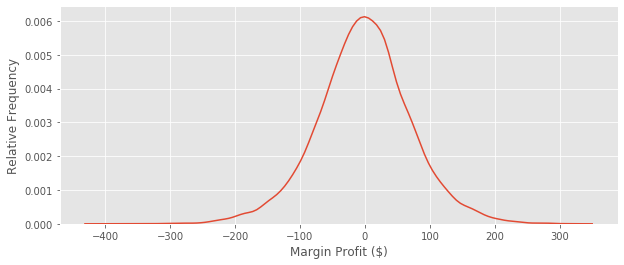

In [30]:
final_margin = margin_percent * end_index_price

margin_profit = final_margin - margin_amount

sns.kdeplot(margin_profit)
plt.ylabel('Relative Frequency')
plt.xlabel('Margin Profit ($)')
#plt.xlim(-50,300)
plt.show()

This makes our strategy extremly risky. A better solution is to short the perpetual for the amount we have in margin.

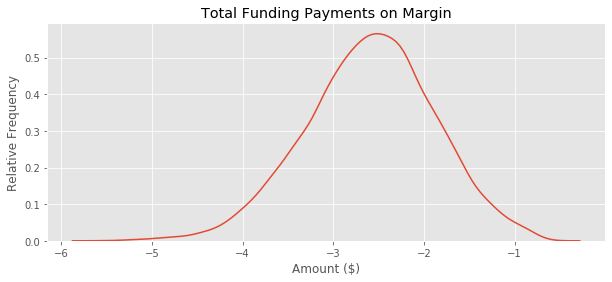

In [31]:
margin_funding_payments = margin_amount * average_funding * 3 * days

sns.kdeplot(margin_funding_payments)
plt.ylabel('Relative Frequency')
plt.xlabel('Amount ($)')
plt.title('Total Funding Payments on Margin')
#plt.xlim(-50,300)
plt.show()

## Calculating Rate of Return

In [32]:
profit = final_long_perpetual_maker + margin_funding_payments

# Rate of Return (simple annualized) on the long perpetual strategy

RR = (profit / margin_amount) * (365 / days) * 100

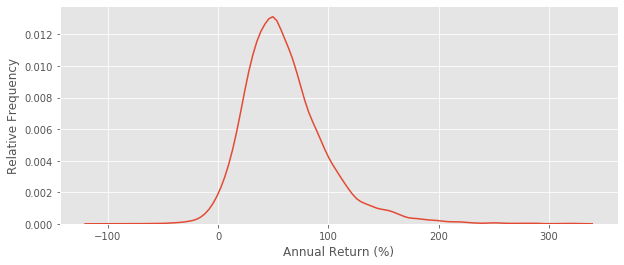

In [33]:
sns.kdeplot(RR)
plt.ylabel('Relative Frequency')
plt.xlabel('Annual Return (%)')
#plt.xlim(-50,300)
plt.show()

In [34]:
RR.mean()

60.80886536449513

In [35]:
RR.std()

38.1283940892174

## Decision Theory

I would like to see is how sensitive our model is to certain parameters. We can use a tool from decision theory to tell us which parameters are worth getting better estimates of.

First we will see how the expected return varies as a function of our model parameters. We can do this by only looking at the modeled situations that happened to have a parameter fall within a specific range.

In [36]:
def linear_transform(x, xs):
    max_xs = np.max(xs)
    min_xs = np.min(xs)
    return (x - min_xs) / (max_xs - min_xs)

In [37]:
end_index_price

array([6677.2765675 , 7507.00731916, 7422.52099285, ..., 9338.01629844,
       8724.6417235 , 8471.90589938])

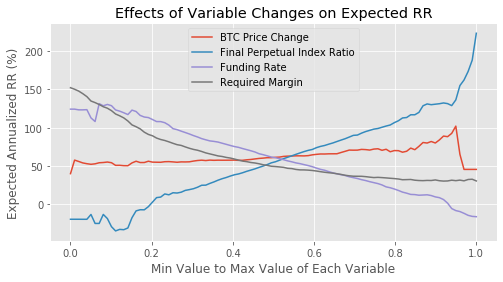

In [38]:
figsize(8,4)

btc_price_change = end_index_price / start_index_price - 1
labels = ['BTC Price Change', 'Final Perpetual Index Ratio', 'Funding Rate', 'Required Margin']
input_variables = [btc_price_change, end_perpetual_ratio, average_funding, margin_percent]

# Sensitivity analysis
# expected value as each variable changes

for index, input_variable in enumerate(input_variables):
    # split variable into groups
    step = (input_variable.max() - input_variable.min())/20
    ys = []
    xs = np.linspace(input_variable.min(), input_variable.max(), 100)
    for i in xs:
        ## values where input_variable is close to i
        bool_array = np.logical_and(input_variable < i + step, input_variable > i - step)
        ys.append(RR[bool_array].mean())
    
    # transform xs to be on scale of 0 to 1 for the graph
    linear_xs = []
    for x in xs:
        linear_xs.append(linear_transform(x, xs))
    plt.plot(linear_xs, ys, label=labels[index])

plt.xlabel('Min Value to Max Value of Each Variable')
plt.ylabel('Expected Annualized RR (%)')
plt.title('Effects of Variable Changes on Expected RR')
plt.legend()
plt.show()

Most of these variables are normally distributed. So there are going to be very few samples near the max and min values. This explains the variance of the RR in the bottom and top 10% of parameter values.

## Expected Value of Information

The final perpetual index ratio, average funding rate, and required margin all had a large effect on the expected return. But the final bitcoin price did not. It had a small effect because we are not able to perfectly match our long and short exposure due to the minimum contract sizes on Deribit. But this shows that it is generally a bitcoin neutral strategy and shows that reducing uncertainty about the final bitcoin price wouldn't contribute to our decision.

However, knowing the exact value of the other variables would be very valuable. In particular, if we knew ahead of time that the perpetual index ratio was going to be low, or if the average funding rate was going to be high, we could choose not to invest and avoid the low RR.

You can quantify the value of that knowledge. It's called the Expected Value of Perfect Information. It's the benefit you get from being omnicienst about some of the unknown quantities in your model.

First we define a loss function. This is the amount that we would have lost if our decision turns out to be incorrect.

In this example our loss function should be comparing a traditional investment to this bitcoin arbitrage strategy.

Our volatiltiy of returns for this strategy are quite high. Plus we face counterparty risk. For the purposes of example lets assume that we prefer a typical index fund if this strategy has less than 25% ER. In reality this would depend on your personal portfolio.

Next we compute the Expected Opurtunity Loss. This is the expected loss if we choose to arbitrage and it turns out that we made the wrong decision, the rate of return was less then 25%.

In [39]:
# Expected Oppurtunity loss if you take the long perpetual arbitrage strateygy
Loss = RR - 25
EOL = -Loss[Loss < 0].sum()/len(Loss)
EOL

1.8051095446388885

That means our expected loss from uncertainty is 1.8% in returns. If we could elimated the uncertianty in our model, we would only reduce the expected loss from making a bad decision by 1.8%. Which is not that much.

## Expected Value of Perfect Partial Information

We can see which parameter has most influence by setting a decision rule and seeing how much our EOL decreases.

Let's look at each parameter to determine an investment decision rule. From the above graph we see that this strategy is always over 25% return for every value of the bitcoin price change and for every value of the required margin. Thus we know that reducing uncertainty about thos variables will not influence our decision. So they have an information value of 0.

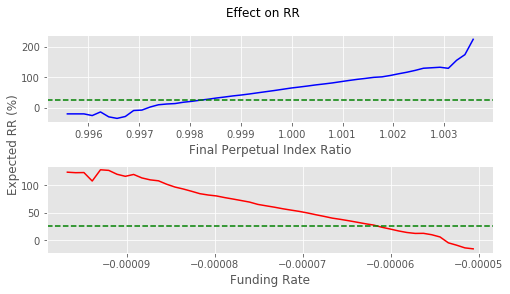

In [40]:
figsize(8,4)
fig, (ax1, ax2) = plt.subplots(2, gridspec_kw={'hspace': 0.5, 'wspace': 0.1})
fig.suptitle('Effect on RR')

# Add big axis for common label
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(b=None)
plt.ylabel("Expected RR (%)")

colors = ['b','r']

# Sensitivity analysis
# expected value as each variable changes
for index, input_variable in enumerate([end_perpetual_ratio, average_funding]):
    step = (input_variable.max() - input_variable.min())/20
    ys = []
    xs = np.linspace(input_variable.min(), input_variable.max(), 50)
    for i in xs:
        ## values where var is close to i
        bool_array = np.logical_and(input_variable < i + step, input_variable > i - step)
        ys.append(RR[bool_array].mean())
    fig.axes[index].plot(xs, ys, color=colors[index])

ax1.set_xlabel('Final Perpetual Index Ratio')
ax2.set_xlabel('Funding Rate')
ax1.axhline(y=25, color='g', linestyle='--')
ax2.axhline(y=25, color='g', linestyle='--')
plt.show()

If we had perfect information we would know not to use this strategy anytime the final perpetual index ratio was below 0.998, and anytime the average funding rate is less than about -0.000065

In [41]:
# Only take investment if we know ratio > 0.998
bool_array = np.logical_and(Loss < 0, end_perpetual_ratio > 0.998)
EOL_with_ratio_knowledge = -Loss[bool_array].sum()/len(Loss)
EOL_with_ratio_knowledge

1.5159815182769

In [42]:
EVPPI_ratio = EOL - EOL_with_ratio_knowledge
EVPPI_ratio

0.2891280263619884

In [43]:
# Only take investment if we know funding rate < -0.000065
bool_array = np.logical_and(Loss < 0, average_funding < -0.000065)
EOL_with_funding_knowledge = -Loss[bool_array].sum()/len(Loss)
EOL_with_funding_knowledge

0.8090044204654081

In [44]:
EVPPI_funding = EOL - EOL_with_funding_knowledge
EVPPI_funding

0.9961051241734804

## EVPPI Results

Removing all uncertainty about the average funding rate is worth 1% more in returns. Removing all uncertainty in the final perpetual index ratio is worth 0.29% in returns. Having complete information of our model is worth 1.8% in returns.

These are all low numbers. Thus it doesn't seem worth it to reduce our uncertainy about these variables by collecting more data on funding rates.

# Conclusion

We created a model that can be used to predict the profitiability of an arbitrage strategy given any future and perpetual prices. If this model is accurate at all, it will be accurate over longer time spans, and should only be used if the future expiration date is more than a few weeks in advance. This model could be turned into an algorithmic trading strategy. It would likely be too slow to run on every live price update. Instead you could run the simulation for a wide variety of future/perpetual price ratios, determine which combinations fit your investment strategy and cache the results for use in a lookup table.

The most promising next step would be to identify a time series model of the perpetual index ratio. That would allow shorter term arbitrage as well as a whole host of other strategies.

In the next part we will look at the actual profitability of the specific example we used and see how it compares with the model.

In [32]:
t = df_5Min['funding'].resample('D').mean().resample('W').mean().resample('M').mean()

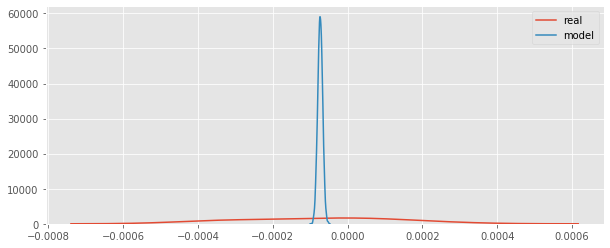

In [33]:
sns.kdeplot(t, label='real')
sns.kdeplot(average_funding, label='model')

In [ ]:
t = df['funding'].resample('M').mean()
sns.kdeplot(t)
sns.kdeplot(average_funding)

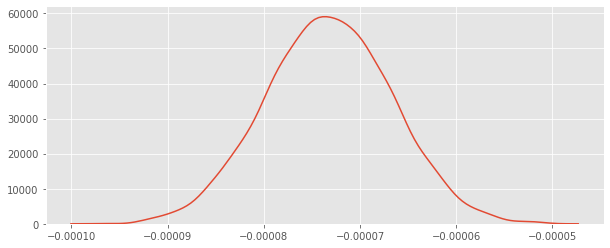

In [28]:
sns.kdeplot(average_funding)

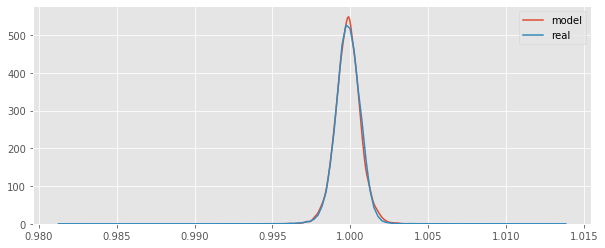

In [35]:
sns.kdeplot(end_perpetual_ratio, label='model')
sns.kdeplot(df_5Min['ratio'], label='real')